Contours from:

- Sunnybrook
- manual 1-100 
- manual 101-200 (selected for prominent stomachs)

In [29]:
import os
import csv
import re
import pickle
import random
import math
import dicom
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from skimage import transform
from sklearn.externals import joblib
from scipy import ndimage
from matplotlib import path

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
with open('../../data_supp/sunnybrook_study_files.pkl', 'rb') as f:
    sunnybrook_study_files = pickle.load(f)
with open('../../data_supp/sunnybrook_contour_files.pkl', 'rb') as f:
    sunnybrook_contour_files = pickle.load(f)
with open('../../data_supp/sunnybrook_series_contour_match.pkl', 'rb') as f:
    sunnybrook_series_contour_match = pickle.load(f)

with open('../../data_supp/filepaths_train.pkl', 'rb') as f:
    filepaths_train = pickle.load(f)

In [31]:
def get_contour_coords_sunnybrook(contour_fpath):
    with open(contour_fpath, 'r') as f:
        reader = csv.reader(f)
        return list([[float(xy) for xy in x[0].split()] for x in reader])
    
def get_contour_coords_manual(contour_fpath):
    with open(contour_fpath, 'r') as f:
        reader = csv.reader(f)
        return list([[float(xy) for xy in x][::-1] for x in reader])

In [32]:
def get_matching_dicom_sunnybrook_contours(study_name, contour_fname):
    for study_fname, study_fpath in sunnybrook_study_files[study_name]:
        if re.compile('IM-{}-{}'.format(sunnybrook_series_contour_match[study_name], contour_fname[8:12])).match(study_fname):
            break
    else:
        return None, None
    return study_fname, study_fpath

def get_matching_dicom_manual_contours(study_num, series_name, contour_fname):
    for fname, fpath in filepaths_train[study_num][series_name]:
        if fname.replace('.dcm', '.csv') == contour_fname:
            break
    else:
        return None, None
    return fname, fpath

### helper functions

In [33]:
def apply_window(arr, window_center, window_width):
    return np.clip(arr, window_center - window_width/2, window_center + window_width/2)

In [34]:
def apply_per_slice_norm(arr):
    mean = np.mean(arr.ravel())
    std = np.std(arr.ravel())
    if std == 0:
        return np.zeros(arr.shape)
    return (arr - mean) / std

In [35]:
def crop_to_square(arr, size):
    x_len, y_len = arr.shape
    shorter_len = min(x_len, y_len)
    x_start = (arr.shape[0] - shorter_len) // 2
    x_end = x_start + shorter_len
    y_start = (arr.shape[1] - shorter_len) // 2
    y_end = y_start + shorter_len
    return transform.resize(arr[x_start:x_end, y_start:y_end], 
                            (size, size), order=1, clip=True, preserve_range=True)

def crop_to_square_normalized(img_orig, pixel_spacing, size):
    img_norm = ndimage.interpolation.zoom(img_orig, [float(x) for x in pixel_spacing], order=0, mode='constant')
    
    length_x, length_y = img_norm.shape
    if length_x >= size:
        x_start = length_x // 2 - size // 2
        x_end = length_x // 2 + size // 2
    else:
        x_start = 0
        x_end = length_x
    if length_y >= size:
        y_start = length_y // 2 - size // 2
        y_end = length_y // 2 + size // 2
    else:
        y_start = 0
        y_end = length_y
    
    img_new = np.zeros((size, size))
    new_x_shift = (size - (x_end - x_start)) // 2
    new_y_shift = (size - (y_end - y_start)) // 2
    img_new[new_x_shift:(new_x_shift + x_end - x_start), 
            new_y_shift:(new_y_shift + y_end - y_start)] = img_norm[x_start:x_end, y_start:y_end]
    
    return img_new

def localize_to_centroid(img, centroid, width_about_centroid):
    # assumes already cropped to square
    x, y = centroid
    x = int(round(x))
    y = int(round(y))
    x_start = x - width_about_centroid // 2
    x_end = x + width_about_centroid // 2
    y_start = y - width_about_centroid // 2
    y_end = y + width_about_centroid // 2
    
    if x_start < 0:
        x_end += (0 - x_start)
        x_start = 0
    if x_end > img.shape[0]:
        x_start -= (img.shape[0] - x_end)
        x_end = img.shape[0]
    if y_start < 0:
        y_end += (0 - y_start)
        y_start = 0
    if y_end > img.shape[1]:
        y_start -= (img.shape[1] - y_end)
        y_end = img.shape[1]
        
    return img[x_start:x_end, y_start:y_end], (x_start, x_end), (y_start, y_end)

In [36]:
def create_area_fill(contour_coords, img_shape):
    '''segment_mask = np.zeros(img_shape).astype(np.bool)
    for x, y in contour_coords:
        segment_mask[round(y), round(x)] = True
    segment_mask = ndimage.morphology.binary_fill_holes(segment_mask)'''
    if len(contour_coords) == 0:
        return np.zeros(img_shape).astype(np.bool)
    else:
        p = path.Path(contour_coords)
        nx, ny = img_shape
        y, x = np.meshgrid(np.arange(nx), np.arange(ny))
        x, y = x.flatten(), y.flatten()
        segment_mask = p.contains_points(np.vstack((x,y)).T)
        segment_mask = segment_mask.reshape((ny,nx)).T.astype(np.bool)
        return segment_mask

In [37]:
def split_img2d(img, mask, factor, nb):
    # assumes square shape
    newsize = img.shape[0] // factor
    splits = []
    for i in range(nb):
        rand_y = random.randint(0, img.shape[0] - newsize)
        rand_x = random.randint(0, img.shape[1] - newsize)
        splits.append((img[rand_y:(rand_y+newsize), rand_x:(rand_x+newsize)],
                       mask[rand_y:(rand_y+newsize), rand_x:(rand_x+newsize)]))
    return splits

In [38]:
def img_augmentation(img, mask, nb_samples, rotation=True, shift=True):
    
    img_aug_pairs = []
        
    for i in range(nb_samples):
    
        img_aug = img
        mask_aug = mask
            
        # shift +/- 0 to 0.2
        if shift:
            shift_y = round(0.2 * random.randrange(-img.shape[0], img.shape[0]))
            shift_x = round(0.2 * random.randrange(-img.shape[1], img.shape[1]))
            img_aug, mask_aug = (ndimage.interpolation.shift(img_aug, (shift_y, shift_x), order=0, mode='constant'),
                                 ndimage.interpolation.shift(mask_aug, (shift_y, shift_x), order=0, mode='constant'))
        
        # rotation +/- 0 to 30 degrees with probability 0.5
        if rotation and random.random() > 0.5:
            angle = random.randrange(-30, 30)
            img_aug, mask_aug = (ndimage.interpolation.rotate(img_aug, angle, axes=(0, 1), 
                                                              order=0, mode='constant', reshape=False),
                                 ndimage.interpolation.rotate(mask_aug, angle, axes=(0, 1), 
                                                              order=0, mode='constant', reshape=False))
        
        img_aug_pairs.append((img_aug, mask_aug))
        
    return img_aug_pairs

### look at sunnybrook contours

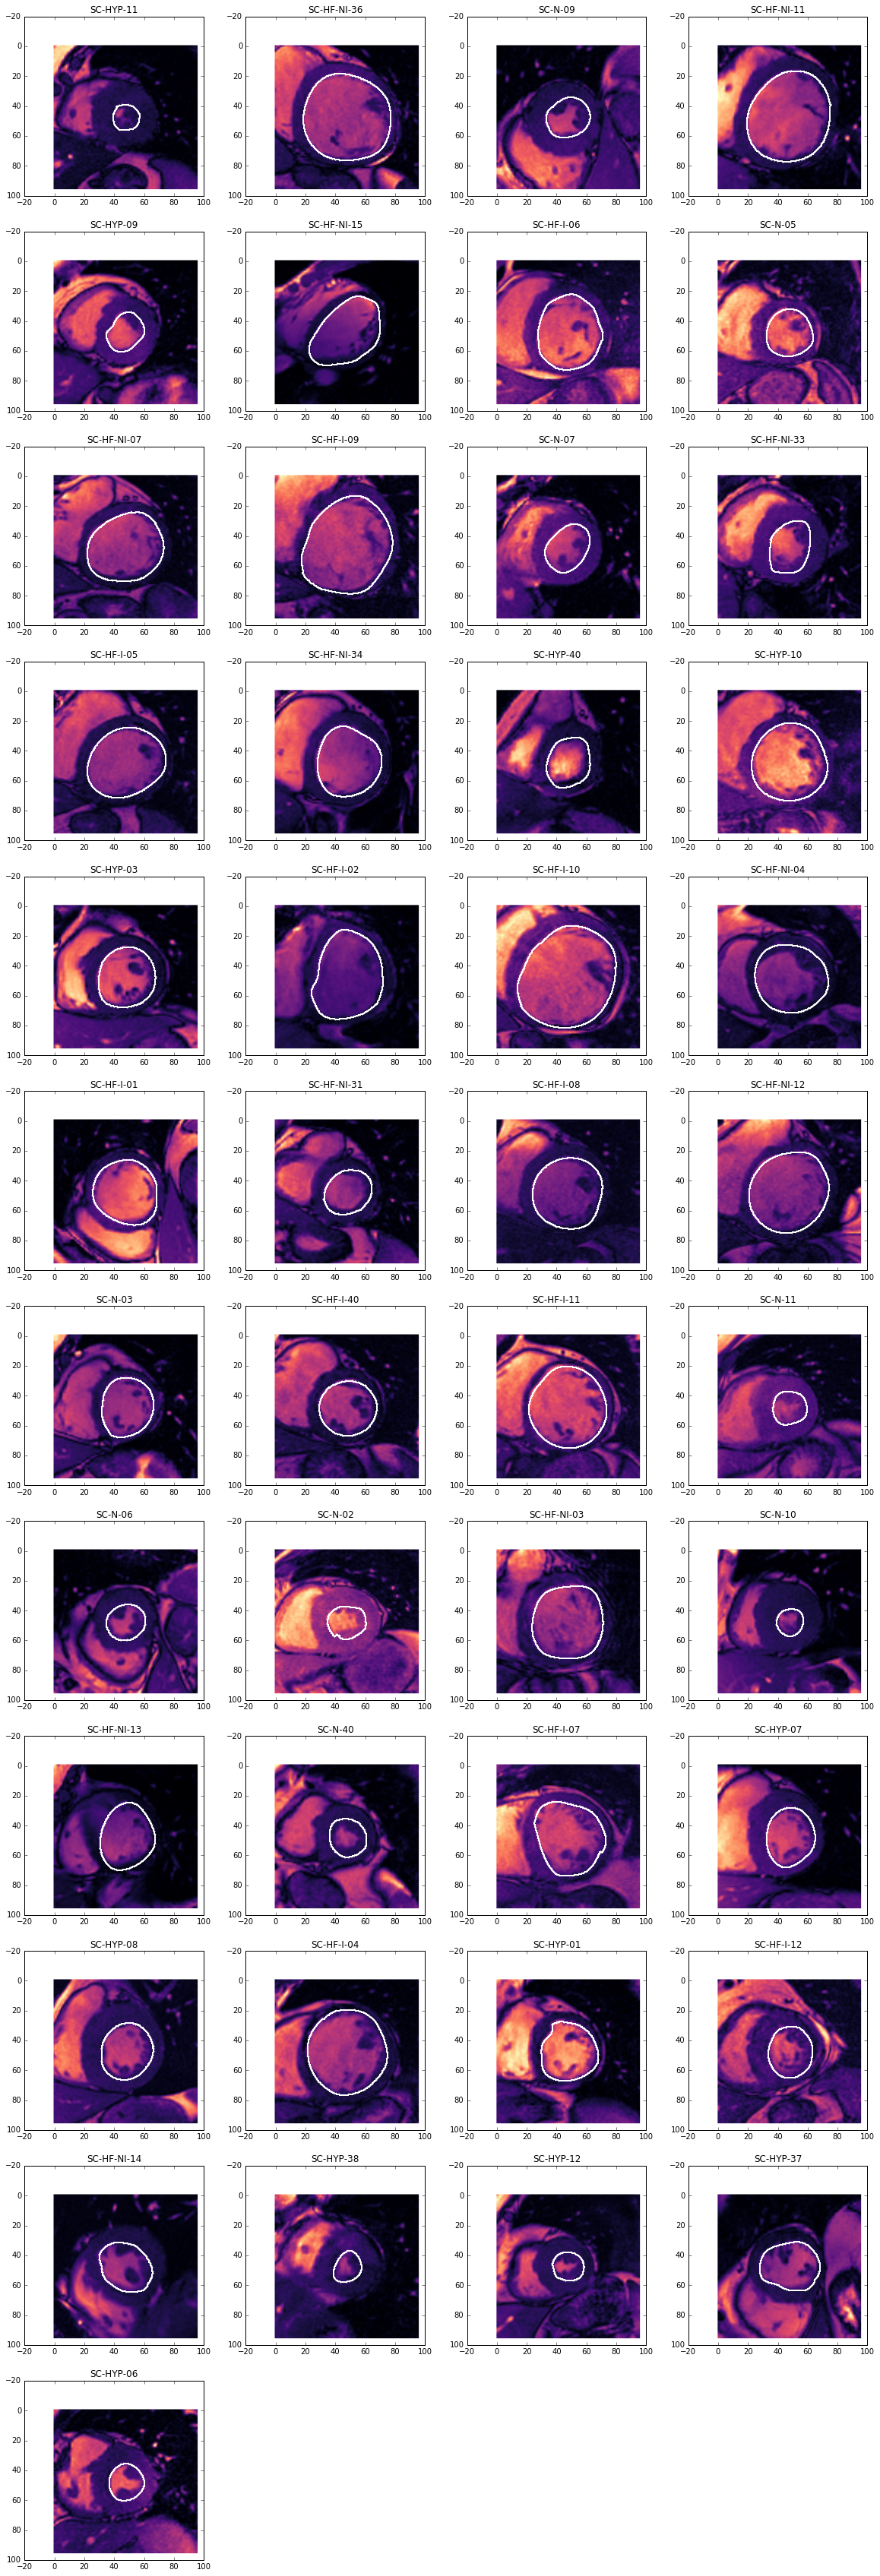

In [11]:
plt.figure(figsize=(20,60))

n = 0
for study_name in sunnybrook_contour_files.keys():
    contour_fname, contour_fpath = sunnybrook_contour_files[study_name]['icontour'][5]
    contour_coords = get_contour_coords_sunnybrook(contour_fpath)
    try:
        n += 1
        for study_fname, study_fpath in sunnybrook_study_files[study_name]:
            if re.compile('IM-{}-{}'.format(sunnybrook_series_contour_match[study_name], 
                                            contour_fname[8:12])).match(study_fname):
                break
        plt.subplot(12, 4, n)
        plt.title(study_name)
        
        centroid = np.mean(contour_coords, axis=0)[::-1].tolist()
        img = dicom.read_file(study_fpath).pixel_array
        img_localized, new_x_coords, new_y_coords = localize_to_centroid(img, centroid, 96)
        
        plt.imshow(img_localized, cmap=plt.cm.magma)
        for i in range(len(contour_coords) - 1):
            y0, x0 = contour_coords[i]
            y1, x1 = contour_coords[i+1]
            x0 -= new_x_coords[0]
            x1 -= new_x_coords[0]
            y0 -= new_y_coords[0]
            y1 -= new_y_coords[0]
            plt.plot([y0, y1], [x0, x1], 'w-', lw=2)
    except:
        print(study_name)

### look at manual contours

In [11]:
def create_contour_fpath_dict():
    contour_filepaths = {}
    for i in tqdm(range(1, 201)):
        if not os.path.exists('../../contouring/contours/{}'.format(i)):
            continue
            
        filepaths = {}
        folders = natsorted([(x.name, os.path.abspath(x.path)) for x in os.scandir('../../contouring/contours/{}'.format(i)) \
                             if x.is_dir()])
        for folder_name, folder_path in folders:
            files = natsorted([(x.name, os.path.abspath(x.path)) for x in os.scandir(folder_path) \
                               if x.is_file() and x.name.endswith('.csv')])
            filepaths[folder_name] = files
        contour_filepaths[i] = filepaths
    
    return contour_filepaths

with open('../../data_supp/contours_fpaths_train_001-200.pkl', 'wb') as f:
    contour_filepaths = create_contour_fpath_dict()
    pickle.dump(contour_filepaths, f)

In [12]:
with open('../../data_supp/contours_fpaths_train_001-200.pkl', 'rb') as f:
    contours_fpaths_train = pickle.load(f)

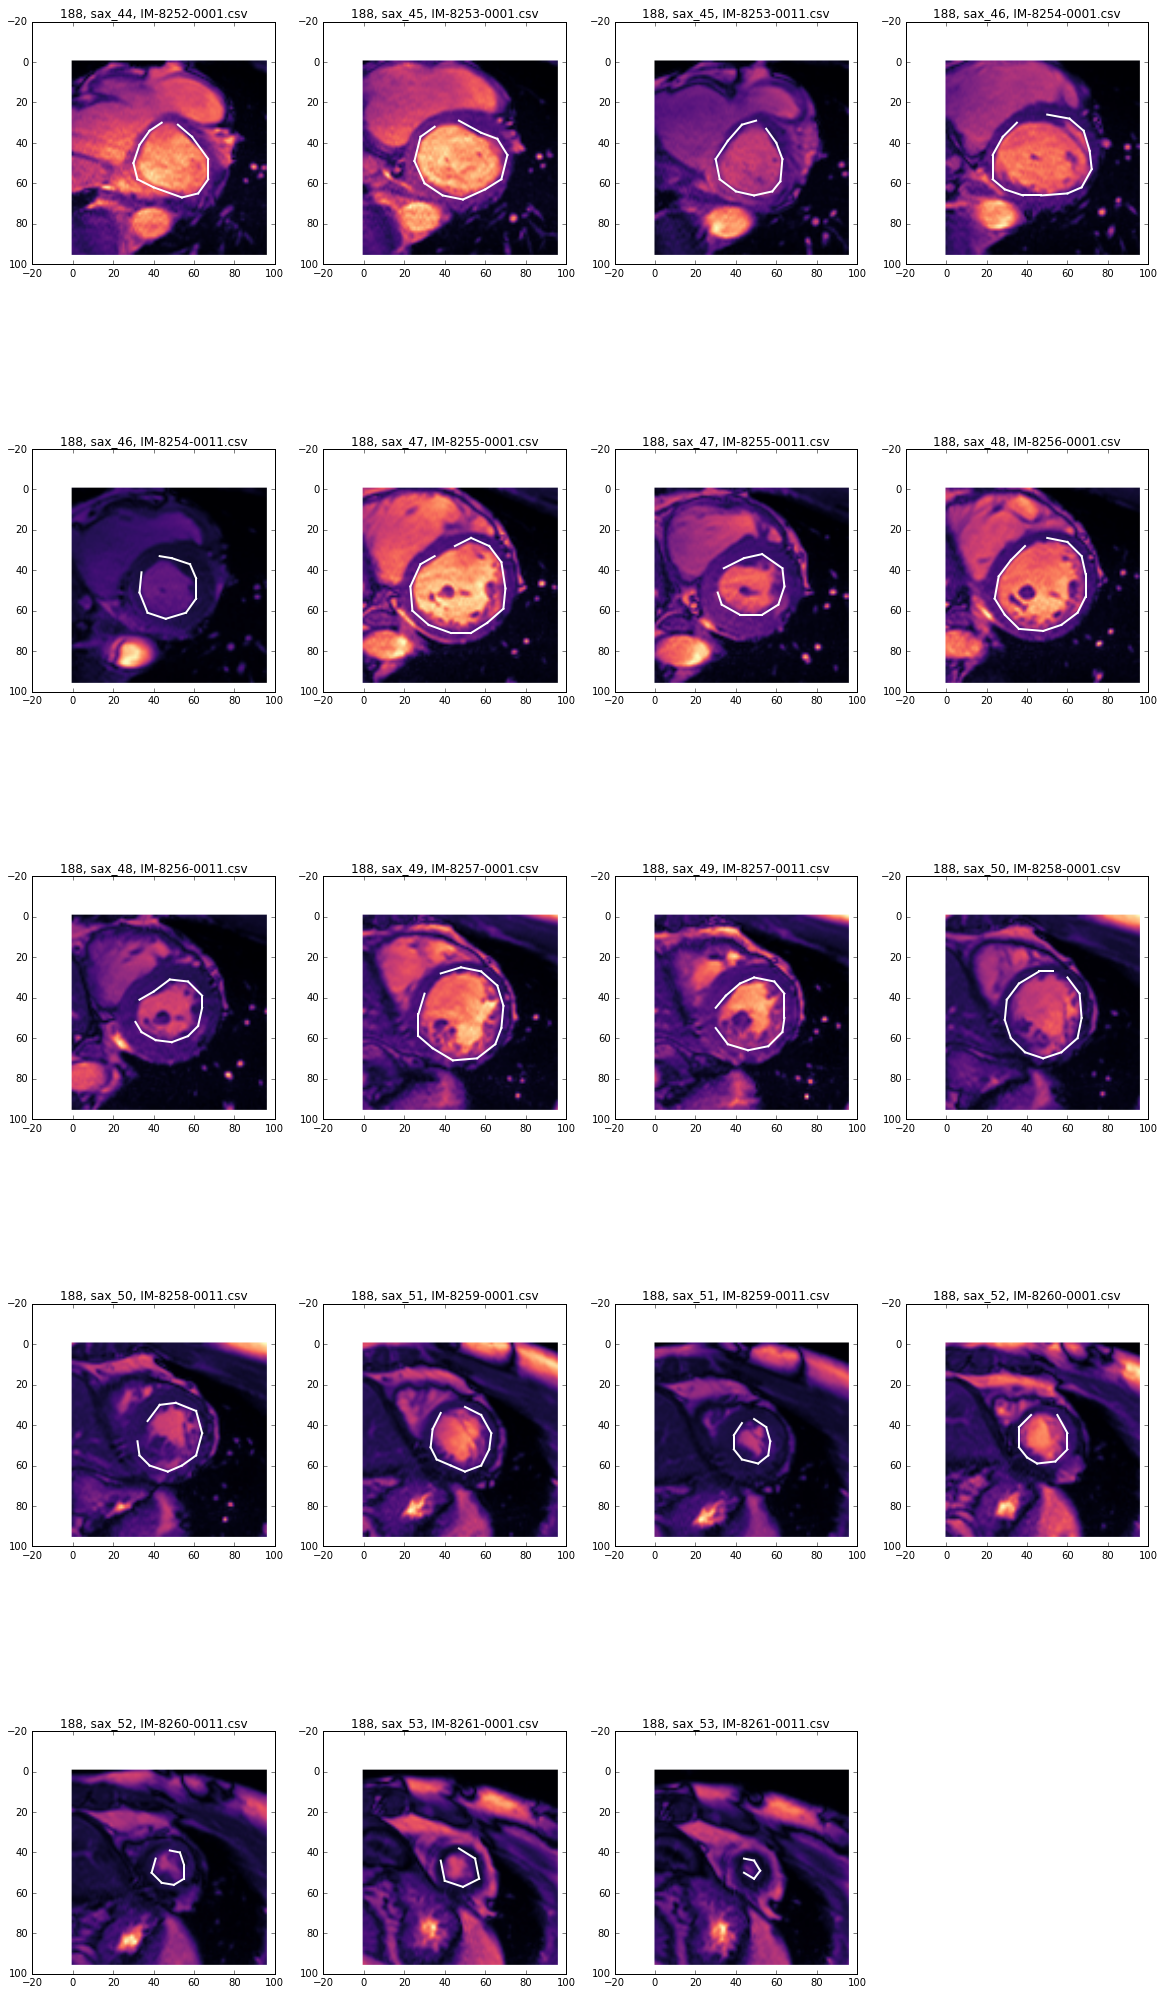

In [13]:
plt.figure(figsize=(20,60))

study_num = 188
n = 0
for series_name in natsorted(contours_fpaths_train[study_num].keys()):
    for contour_fname, contour_fpath in contours_fpaths_train[study_num][series_name]:
        contour_coords = get_contour_coords_manual(contour_fpath)
        if len(contour_coords) == 0:
            continue
        try:
            n += 1
            fname, fpath = get_matching_dicom_manual_contours(study_num, series_name, contour_fname)
            plt.subplot(8, 4, n)
            plt.title('{}, {}, {}'.format(study_num, series_name, contour_fname))
            
            centroid = np.mean(contour_coords, axis=0)[::-1].tolist()
            img = dicom.read_file(fpath).pixel_array
            img_localized, new_x_coords, new_y_coords = localize_to_centroid(img, centroid, 96)

            plt.imshow(img_localized, cmap=plt.cm.magma)
            for i in range(len(contour_coords) - 1):
                y0, x0 = contour_coords[i]
                y1, x1 = contour_coords[i+1]
                x0 -= new_x_coords[0]
                x1 -= new_x_coords[0]
                y0 -= new_y_coords[0]
                y1 -= new_y_coords[0]
                plt.plot([y0, y1], [x0, x1], 'w-', lw=2)
        except:
            print(study_num)

### create training data

In [16]:
sunnybrook_contours_validation = random.sample(list(sunnybrook_contour_files.keys()), 5)
sunnybrook_contours_training = [study for study in list(sunnybrook_contour_files.keys()) \
                                if study not in sunnybrook_contours_validation]

In [17]:
print(sunnybrook_contours_validation)
print(sunnybrook_contours_training)

['SC-HF-I-10', 'SC-N-09', 'SC-HF-NI-36', 'SC-HYP-40', 'SC-HF-NI-34']
['SC-HYP-11', 'SC-HF-NI-11', 'SC-HYP-09', 'SC-HF-NI-15', 'SC-HF-I-06', 'SC-N-05', 'SC-HF-NI-07', 'SC-HF-I-09', 'SC-N-07', 'SC-HF-NI-33', 'SC-HF-I-05', 'SC-HYP-10', 'SC-HYP-03', 'SC-HF-I-02', 'SC-HF-NI-04', 'SC-HF-I-01', 'SC-HF-NI-31', 'SC-HF-I-08', 'SC-HF-NI-12', 'SC-N-03', 'SC-HF-I-40', 'SC-HF-I-11', 'SC-N-11', 'SC-N-06', 'SC-N-02', 'SC-HF-NI-03', 'SC-N-10', 'SC-HF-NI-13', 'SC-N-40', 'SC-HF-I-07', 'SC-HYP-07', 'SC-HYP-08', 'SC-HF-I-04', 'SC-HYP-01', 'SC-HF-I-12', 'SC-HF-NI-14', 'SC-HYP-38', 'SC-HYP-12', 'SC-HYP-37', 'SC-HYP-06']


In [18]:
manual_contours_validation = random.sample(list(contours_fpaths_train.keys()), 13)
manual_contours_training = [study_num for study_num in list(contours_fpaths_train.keys()) \
                            if study_num not in manual_contours_validation]

In [19]:
print(manual_contours_validation)
print(manual_contours_training)

[55, 49, 25, 1, 54, 160, 56, 39, 86, 82, 33, 188, 31]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 120, 122, 124, 126, 140, 142, 146, 148, 161, 164, 165, 167, 168, 170, 172, 176, 180, 183, 192, 197, 198]


In [20]:
data_full_training = []
labels_full_training = []
data_full_validation = []
labels_full_validation = []

full_size = 256
local_size = 96

# sunnybrook
for study_name in tqdm(sunnybrook_contour_files.keys()):
    for contour_fname, contour_fpath in sunnybrook_contour_files[study_name]['icontour']:
        contour_coords = get_contour_coords_sunnybrook(contour_fpath)
        study_fname, study_fpath = get_matching_dicom_sunnybrook_contours(study_name, contour_fname)
        if study_fpath is None:
            continue
            
        df = dicom.read_file(study_fpath)
        img = df.pixel_array
        segment_mask = create_area_fill(contour_coords, img.shape)
        
        img_processed = crop_to_square(img, full_size)
        segment_mask_processed = crop_to_square(segment_mask, full_size)

        centroid = np.mean(np.where(segment_mask_processed > 0), axis=1)
        img_processed_localized, _, _ = localize_to_centroid(img_processed, centroid, local_size)
        segment_mask_processed_localized, _, _ = localize_to_centroid(segment_mask_processed, centroid, local_size)
        
        
        for image_aug, mask_aug in img_augmentation(img_processed_localized, segment_mask_processed_localized, 
                                                    10, rotation=True, shift=True):
            
            image_aug = apply_per_slice_norm(image_aug)
        
            if study_name in sunnybrook_contours_training:
                data_full_training.append(np.expand_dims(image_aug, axis=0))
                labels_full_training.append(mask_aug)
            elif study_name in sunnybrook_contours_validation:
                data_full_validation.append(np.expand_dims(image_aug, axis=0))
                labels_full_validation.append(mask_aug)

# manual set
for study_num in tqdm(natsorted(contours_fpaths_train.keys())):
    for series_name in natsorted(contours_fpaths_train[study_num].keys()):
        for contour_fname, contour_fpath in contours_fpaths_train[study_num][series_name]:
            contour_coords = get_contour_coords_manual(contour_fpath)
            if len(contour_coords) == 0:
                continue
            study_fname, study_fpath = get_matching_dicom_manual_contours(study_num, series_name, contour_fname)
            if study_fpath is None:
                continue
            
            df = dicom.read_file(study_fpath)
            img = df.pixel_array
            segment_mask = create_area_fill(contour_coords, img.shape)

            img_processed = crop_to_square(img, full_size)
            segment_mask_processed = crop_to_square(segment_mask, full_size)
            
            centroid = np.mean(np.where(segment_mask_processed > 0), axis=1)
            img_processed_localized, _, _ = localize_to_centroid(img_processed, centroid, local_size)
            segment_mask_processed_localized, _, _ = localize_to_centroid(segment_mask_processed, centroid, local_size)

            for image_aug, mask_aug in img_augmentation(img_processed_localized, segment_mask_processed_localized, 
                                                        10, rotation=True, shift=True):

                image_aug = apply_per_slice_norm(image_aug)

                if study_num in manual_contours_training:
                    data_full_training.append(np.expand_dims(image_aug, axis=0))
                    labels_full_training.append(mask_aug)
                elif study_num in manual_contours_validation:
                    data_full_validation.append(np.expand_dims(image_aug, axis=0))
                    labels_full_validation.append(mask_aug)

data_full_training = np.array(data_full_training).astype(np.float32)
labels_full_training = np.array(labels_full_training).astype(np.bool)
data_full_validation = np.array(data_full_validation).astype(np.float32)
labels_full_validation = np.array(labels_full_validation).astype(np.bool)

In [21]:
print(data_full_training.shape, labels_full_training.shape)
print(data_full_validation.shape, labels_full_validation.shape)

(25540, 1, 96, 96) (25540, 96, 96)
(3210, 1, 96, 96) (3210, 96, 96)


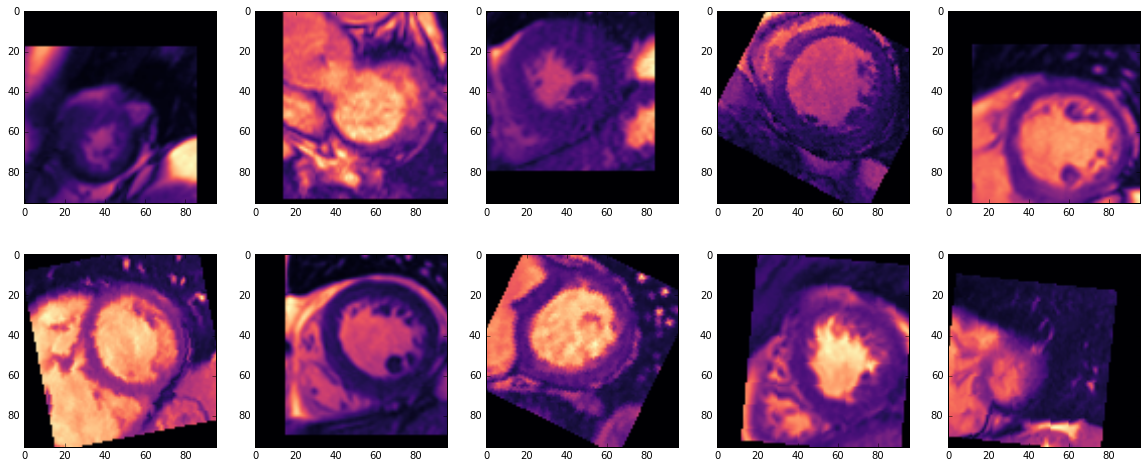

In [22]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(data_full_training[random.randint(0,data_full_training.shape[0]),0,:,:], cmap=plt.cm.magma)

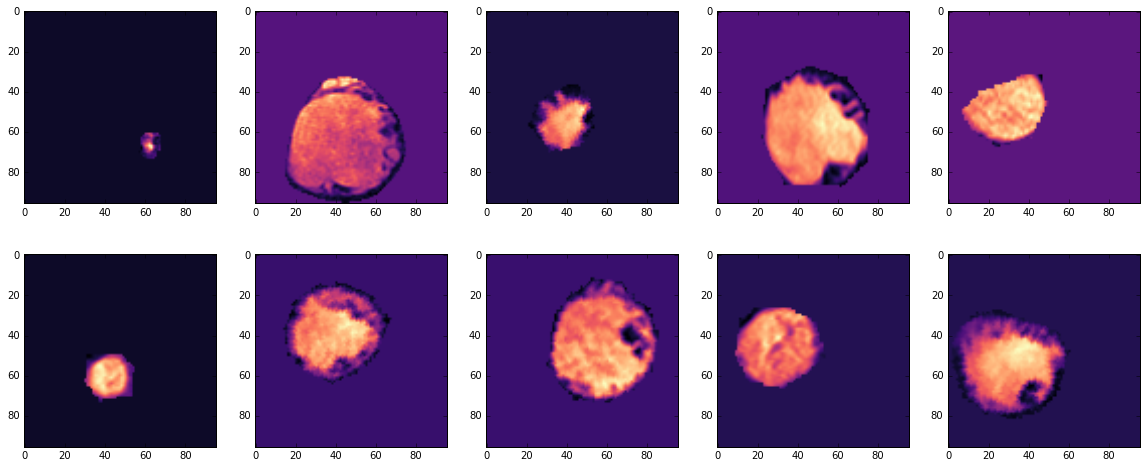

In [23]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    rand_i = random.randint(0,data_full_training.shape[0])
    plt.imshow(data_full_training[rand_i,0,:,:] * \
               labels_full_training[rand_i,:,:], cmap=plt.cm.magma)

In [24]:
shuffle_index = list(range(data_full_training.shape[0]))
random.shuffle(shuffle_index)
data_full_training = data_full_training[shuffle_index]
labels_full_training = labels_full_training[shuffle_index]

shuffle_index = list(range(data_full_validation.shape[0]))
random.shuffle(shuffle_index)
data_full_validation = data_full_validation[shuffle_index]
labels_full_validation = labels_full_validation[shuffle_index]

In [25]:
joblib.dump((sunnybrook_contours_validation, sunnybrook_contours_training,
             manual_contours_validation, manual_contours_training,
             data_full_training, labels_full_training,
             data_full_validation, labels_full_validation), 
            '../../data_proc/trainset3_manual200_plus_sunnybrook_local.pkl')

['../../data_proc/trainset3_manual200_plus_sunnybrook_local.pkl',
 '../../data_proc/trainset3_manual200_plus_sunnybrook_local.pkl_01.npy',
 '../../data_proc/trainset3_manual200_plus_sunnybrook_local.pkl_02.npy',
 '../../data_proc/trainset3_manual200_plus_sunnybrook_local.pkl_03.npy',
 '../../data_proc/trainset3_manual200_plus_sunnybrook_local.pkl_04.npy']

### training

In [26]:
from keras.models import Sequential, Graph
from keras.layers.core import Activation, Dense, Dropout, Flatten, Merge, Reshape, Lambda
from keras.layers.core import TimeDistributedDense, TimeDistributedMerge
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ParametricSoftplus, ELU
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout, GaussianNoise
from keras.utils import np_utils, generic_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

# for preventing python max recursion limit error
import sys
sys.setrecursionlimit(50000)

Using Theano backend.
Using gpu device 3: Tesla K80 (CNMeM is disabled)


In [39]:
(sunnybrook_contours_validation, sunnybrook_contours_training,
 manual_contours_validation, manual_contours_training,
 data_full_training, labels_full_training,
 data_full_validation, labels_full_validation) = joblib.load('../../data_proc/trainset3_manual200_plus_sunnybrook_local.pkl')

In [40]:
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=None, keepdims=False))

def binaryCE(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=None, keepdims=False)

In [41]:
from keras import initializations
from keras.layers.core import Layer
from keras import backend as K


class Rotate90(Layer):
    def __init__(self, direction='clockwise', **kwargs):
        super(Rotate90, self).__init__(**kwargs)
        self.direction = direction

    def get_output(self, train):
        X = self.get_input(train)
        if self.direction == 'clockwise':
            return X.transpose((0, 2, 1))[:, :, ::-1]
        elif self.direction == 'counterclockwise':
            return X.transpose((0, 2, 1))[:, ::-1, :]
        else:
            raise

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Rotate90, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [43]:
model = Graph()

model.add_input(name='input', input_shape=(1, 96, 96))

model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-1', input='input')
model.add_node(BatchNormalization(), name='conv-1-1-bn', input='conv-1-1')
model.add_node(ELU(), name='conv-1-1-activ', input='conv-1-1-bn')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-1-2', input='conv-1-1-activ')
model.add_node(BatchNormalization(), name='conv-1-2-bn', input='conv-1-2')
model.add_node(ELU(), name='conv-1-2-activ', input='conv-1-2-bn')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-1', input='conv-1-2-activ')

model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-1', input='pool-1')
model.add_node(BatchNormalization(), name='conv-2-1-bn', input='conv-2-1')
model.add_node(ELU(), name='conv-2-1-activ', input='conv-2-1-bn')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-2-2', input='conv-2-1-activ')
model.add_node(BatchNormalization(), name='conv-2-2-bn', input='conv-2-2')
model.add_node(ELU(), name='conv-2-2-activ', input='conv-2-2-bn')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-2', input='conv-2-2-activ')

model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-1', input='pool-2')
model.add_node(BatchNormalization(), name='conv-3-1-bn', input='conv-3-1')
model.add_node(ELU(), name='conv-3-1-activ', input='conv-3-1-bn')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-2', input='conv-3-1-activ')
model.add_node(BatchNormalization(), name='conv-3-2-bn', input='conv-3-2')
model.add_node(ELU(), name='conv-3-2-activ', input='conv-3-2-bn')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-3-3', input='conv-3-2-activ')
model.add_node(BatchNormalization(), name='conv-3-3-bn', input='conv-3-3')
model.add_node(ELU(), name='conv-3-3-activ', input='conv-3-3-bn')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-3', input='conv-3-3-activ')

model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-1', input='pool-3')
model.add_node(BatchNormalization(), name='conv-4-1-bn', input='conv-4-1')
model.add_node(ELU(), name='conv-4-1-activ', input='conv-4-1-bn')
model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-2', input='conv-4-1-activ')
model.add_node(BatchNormalization(), name='conv-4-2-bn', input='conv-4-2')
model.add_node(ELU(), name='conv-4-2-activ', input='conv-4-2-bn')
model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='conv-4-3', input='conv-4-2-activ')
model.add_node(BatchNormalization(), name='conv-4-3-bn', input='conv-4-3')
model.add_node(ELU(), name='conv-4-3-activ', input='conv-4-3-bn')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='pool-4', input='conv-4-3-activ')

model.add_node(Flatten(), name='flatten', input='pool-4')
model.add_node(Dense(2304, activation='relu'), name='fc-1', input='flatten')
model.add_node(Dropout(0.5), name='dropout-1', input='fc-1')
model.add_node(Dense(2304, activation='relu'), name='fc-2', input='dropout-1')
model.add_node(Dropout(0.5), name='dropout-2', input='fc-2')
model.add_node(Reshape((64, 6, 6)), name='reshape', input='dropout-2')

model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-1', input='reshape')
model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-1', input='unpool-1')
model.add_node(BatchNormalization(), name='deconv-1-1-bn', input='deconv-1-1')
model.add_node(ELU(), name='deconv-1-1-activ', input='deconv-1-1-bn')
model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-2', input='deconv-1-1-activ')
model.add_node(BatchNormalization(), name='deconv-1-2-bn', input='deconv-1-2')
model.add_node(ELU(), name='deconv-1-2-activ', input='deconv-1-2-bn')
model.add_node(Convolution2D(512, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-1-3', input='deconv-1-2-activ')
model.add_node(BatchNormalization(), name='deconv-1-3-bn', input='deconv-1-3')
model.add_node(ELU(), name='deconv-1-3-activ', input='deconv-1-3-bn')

model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-2', input='deconv-1-3-activ')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-1', input='unpool-2')
model.add_node(BatchNormalization(), name='deconv-2-1-bn', input='deconv-2-1')
model.add_node(ELU(), name='deconv-2-1-activ', input='deconv-2-1-bn')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-2', input='deconv-2-1-activ')
model.add_node(BatchNormalization(), name='deconv-2-2-bn', input='deconv-2-2')
model.add_node(ELU(), name='deconv-2-2-activ', input='deconv-2-2-bn')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-2-3', input='deconv-2-2-activ')
model.add_node(BatchNormalization(), name='deconv-2-3-bn', input='deconv-2-3')
model.add_node(ELU(), name='deconv-2-3-activ', input='deconv-2-3-bn')

model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-3', input='deconv-2-3-activ')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-1', input='unpool-3')
model.add_node(BatchNormalization(), name='deconv-3-1-bn', input='deconv-3-1')
model.add_node(ELU(), name='deconv-3-1-activ', input='deconv-3-1-bn')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-3-2', input='deconv-3-1-activ')
model.add_node(BatchNormalization(), name='deconv-3-2-bn', input='deconv-3-2')
model.add_node(ELU(), name='deconv-3-2-activ', input='deconv-3-2-bn')

model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='unpool-4', input='deconv-3-2-activ')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-1', input='unpool-4')
model.add_node(BatchNormalization(), name='deconv-4-1-bn', input='deconv-4-1')
model.add_node(ELU(), name='deconv-4-1-activ', input='deconv-4-1-bn')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='deconv-4-2', input='deconv-4-1-activ')
model.add_node(BatchNormalization(), name='deconv-4-2-bn', input='deconv-4-2')
model.add_node(ELU(), name='deconv-4-2-activ', input='deconv-4-2-bn')

model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='prob-map', input='deconv-4-2-activ')
model.add_node(Reshape((96, 96)), name='prob-map-reshape', input='prob-map')
model.add_node(Dropout(0.5), name='prob-map-dropout', input='prob-map-reshape')

model.add_node(GRU(96, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-we', input='prob-map-dropout')
model.add_node(GRU(96, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-ew', input='prob-map-dropout')
model.add_node(TimeDistributedDense(96, init='uniform', activation='sigmoid'),
               name='rnn-1', inputs=['rnn-we', 'rnn-ew'], merge_mode='concat', concat_axis=-1)

model.add_node(Rotate90(direction='counterclockwise'), name='rotate', input='prob-map-dropout')
model.add_node(GRU(96, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-ns', input='rotate')
model.add_node(GRU(96, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-sn', input='rotate')
model.add_node(TimeDistributedDense(96, init='uniform', activation='sigmoid'),
               name='rnn-2-rotated', inputs=['rnn-ns', 'rnn-sn'], merge_mode='concat', concat_axis=-1)
model.add_node(Rotate90(direction='clockwise'), name='rnn-2', input='rnn-2-rotated')

model.add_node(Activation('linear'), name='pre-output', inputs=['rnn-1', 'rnn-2'], merge_mode='mul')
model.add_output(name='output', input='pre-output')

model.compile('adam', {'output': binaryCE})

In [ ]:
batch_size = 64
nb_epoch = 100

checkpointer = ModelCheckpoint(filepath='../../model_weights/weights_trainset3_local.hdf5',
                               verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.fit({'input': data_full_training, 'output': labels_full_training},
          batch_size=batch_size, nb_epoch=nb_epoch, verbose=2, shuffle=True,
          validation_data={'input': data_full_validation, 'output': labels_full_validation},
          callbacks=[checkpointer, earlystopping])

The above training code is run separately in a script.

### test segmentation

In [44]:
model.load_weights('../../model_weights/weights_trainset3_local.hdf5')

16481


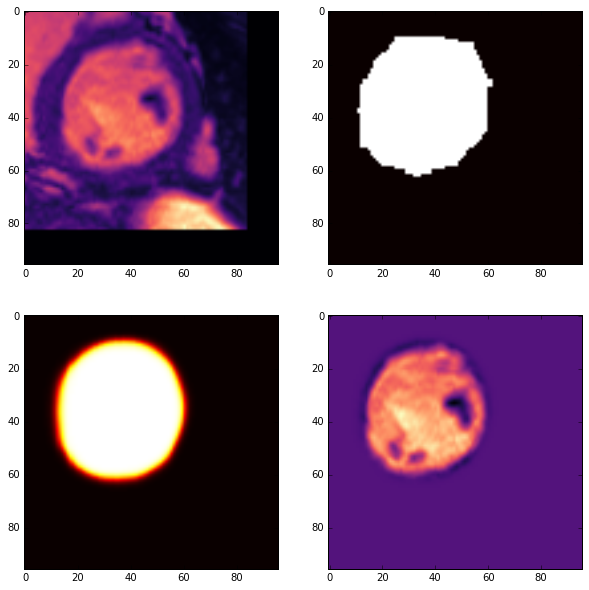

In [45]:
i = random.randint(0, data_full_training.shape[0])
print(i)

img = data_full_training[i,0,:,:]
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(img, cmap=plt.cm.magma)
plt.subplot(2,2,2)
plt.imshow(labels_full_training[i,:,:], cmap=plt.cm.hot)

segmentation = model.predict({'input': np.expand_dims(np.expand_dims(img, axis=0), axis=0)}, 
                             verbose=0)['output'][0,:,:]


plt.subplot(2,2,3)
plt.imshow(segmentation, cmap=plt.cm.hot)

plt.subplot(2,2,4)
plt.imshow(img * segmentation, cmap=plt.cm.magma)

1935


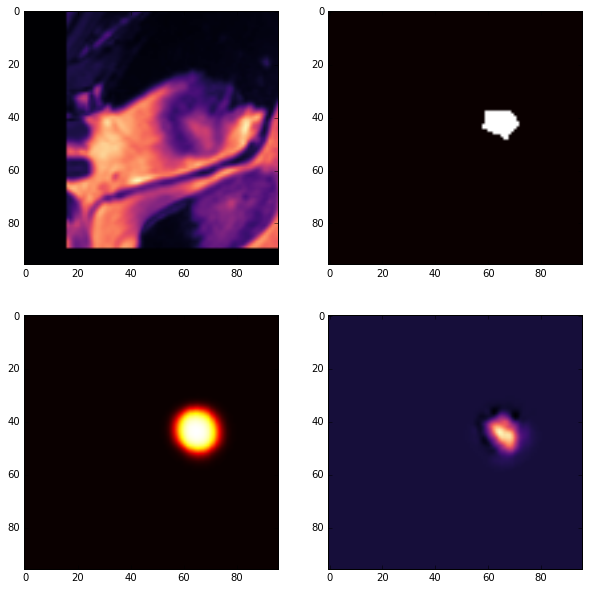

In [46]:
i = random.randint(0, data_full_validation.shape[0])
print(i)

img = data_full_validation[i,0,:,:]
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(img, cmap=plt.cm.magma)
plt.subplot(2,2,2)
plt.imshow(labels_full_validation[i,:,:], cmap=plt.cm.hot)

segmentation = model.predict({'input': np.expand_dims(np.expand_dims(img, axis=0), axis=0)}, 
                             verbose=0)['output'][0,:,:]


plt.subplot(2,2,3)
plt.imshow(segmentation, cmap=plt.cm.hot)

plt.subplot(2,2,4)
plt.imshow(img * segmentation, cmap=plt.cm.magma)